In [2]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [100]:
df = pd.read_csv('G:/Anaconda/Jupyter/Exam/RealTest/7/Test_Scenario5.csv')
df.head()

PNR_NUMBER  PRODUCT ID PRODUCT CODE PRODUCT CATEGORY  \
0     D248QD       73856    EXTRA BAG          BAGGAGE   
1     XRD2F3       43713    FIRST ROW             SEAT   
2     XRD2F3       43712    EXTRA BAG          BAGGAGE   
3     S22DBD       67886    FIRST ROW             SEAT   
4     DD2HC2       74942    FIRST ROW             SEAT   

              PRODUCT REMARKS DATE OF PURCHASE  FLIGHT_NUMBER FLIGHT_DATE  \
0  20***XBAG :BAG WEIGHT 20KG        15-Jan-19            103   16-Jan-19   
1                         NaN        14-Jan-19            103   16-Jan-19   
2  20***XBAG :BAG WEIGHT 20KG        14-Jan-19            103   16-Jan-19   
3                         NaN        15-Jan-19            101   16-Jan-19   
4                         NaN        15-Jan-19            105   16-Jan-19   

  CABIN_CLASS ORIGIN DESTINATION COUNTRY PASSENGER_TITLE PASSENGER_TYPE  \
0     ECONOMY    HAN         DAD      VN              MS          ADULT   
1     ECONOMY    HAN         DAD      VN             MRS          ADULT   
2     ECONOMY    HAN         DAD      VN             MRS          ADULT   
3     ECONOMY    HAN         DAD      VN             MRS          ADULT   
4     ECONOMY    HAN         DAD      VN              MR          ADULT   

  GENDER  AGE          PRODUCT DESCRIPTION  
0    NaN   31               EXCESS BAGGAGE  
1    NaN   54  PRE RESERVED SEAT BAS FRONT  
2    NaN   54               EXCESS BAGGAGE  
3    NaN   25  PRE RESERVED SEAT BAS FRONT  
4    NaN    0  PRE RESERVED SEAT BAS FRONT

In [101]:
df.shape

(13406, 17)

In [105]:
df = df.drop(columns=['PRODUCT REMARKS', 'GENDER'])

In [107]:
df.to_csv('dftest.csv')

In [108]:
# check for missing values
df.isnull().sum()

PNR_NUMBER              0
PRODUCT ID              0
PRODUCT CODE            0
PRODUCT CATEGORY        0
DATE OF PURCHASE        0
FLIGHT_NUMBER           0
FLIGHT_DATE             0
CABIN_CLASS             0
ORIGIN                  0
DESTINATION             0
COUNTRY                21
PASSENGER_TITLE         0
PASSENGER_TYPE          0
AGE                     0
PRODUCT DESCRIPTION     0
dtype: int64

In [109]:
# remove missing values
df.dropna(inplace=True)

In [110]:
df['PRODUCT ID']= df['PRODUCT ID'].astype(str)

In [111]:
passengers = df["PNR_NUMBER"].unique().tolist()
len(passengers)

7465

In [112]:
# shuffle customer ID's
random.shuffle(passengers)

# extract 90% of customer ID's
passengers_train = [passengers[i] for i in range(round(0.9*len(passengers)))]

# split data into train and validation set
train_df = df[df['PNR_NUMBER'].isin(passengers_train)]
validation_df = df[~df['PNR_NUMBER'].isin(passengers_train)]

In [113]:
# list to capture purchase history of the customers
bookings_train = []

# populate the list with the product codes
for i in tqdm(passengers_train):
    temp = train_df[train_df["PNR_NUMBER"] == i]["PRODUCT ID"].tolist()
    bookings_train.append(temp)

100%|██████████| 6718/6718 [00:07<00:00, 936.93it/s]


In [114]:
# list to capture purchase history of the customers
bookings_val = []

# populate the list with the product codes
for i in tqdm(validation_df['PNR_NUMBER'].unique()):
    temp = validation_df[validation_df["PNR_NUMBER"] == i]["PRODUCT ID"].tolist()
    bookings_val.append(temp)

100%|██████████| 747/747 [00:00<00:00, 2046.15it/s]


In [115]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
# train word2vec model
model = Word2Vec(sentences=common_texts, size=100, window=5, min_count=1, workers=4)

model.save("word2vec.model")

#model.train(bookings_train, total_examples = model.corpus_count, 
#            epochs=10, report_delay=1)

In [116]:
model = Word2Vec.load("word2vec.model")

In [117]:
model.train(bookings_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(0, 120010)

In [118]:
model.init_sims(replace=True)

In [119]:
print(model)


Word2Vec(vocab=12, size=100, alpha=0.025)


In [120]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(12, 100)

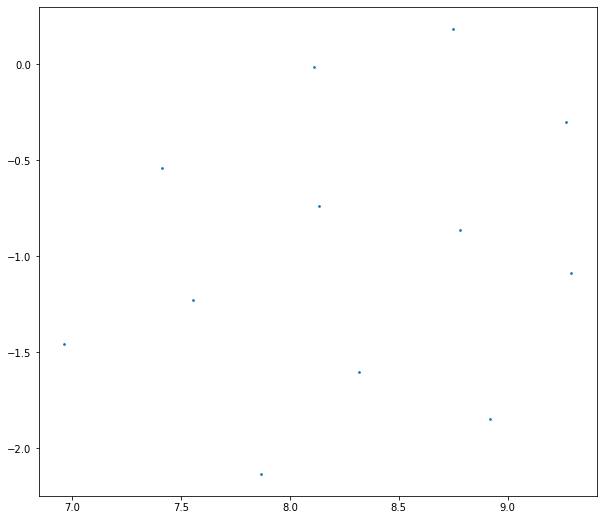

In [121]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [122]:
products = train_df[["PRODUCT ID", "PRODUCT CODE"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='PRODUCT ID', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('PRODUCT ID')['PRODUCT CODE'].apply(list).to_dict()

In [125]:
# test the dictionary
products_dict['1005680']

['EXTRA LEG SEAT']

In [126]:
def similar_products(v, n = 2):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
    return new_ms   

In [124]:
print(products_dict)

{'1000009': ['FIRST ROW'], '1000512': ['EXTRA BAG'], '1000685': ['EXTRA BAG'], '1000927': ['EXTRA BAG'], '1000946': ['EXTRA BAG'], '1001007': ['EXTRA BAG'], '1001241': ['EXTRA BAG'], '1001243': ['EXTRA BAG'], '1002537': ['FIRST ROW'], '1002614': ['FIRST ROW'], '1003208': ['EXTRA BAG'], '1005680': ['EXTRA LEG SEAT'], '1005681': ['EXTRA LEG SEAT'], '1005740': ['EXTRA LEG SEAT'], '1005741': ['EXTRA LEG SEAT'], '1006864': ['EXTRA BAG'], '1006952': ['EXTRA BAG'], '1007300': ['EXTRA BAG'], '1008160': ['EXTRA BAG'], '100880': ['EXTRA BAG'], '1008840': ['EXTRA BAG'], '1008936': ['EXTRA BAG'], '1009085': ['EXTRA LEG SEAT'], '1009364': ['EXTRA BAG'], '1009401': ['EXTRA BAG'], '1009420': ['EXTRA BAG'], '1009536': ['EXTRA BAG'], '1009615': ['EXTRA BAG'], '1009617': ['EXTRA BAG'], '1010946': ['EXTRA BAG'], '1011308': ['FIRST ROW'], '1011462': ['FIRST ROW'], '1011510': ['FIRST ROW'], '1011511': ['FIRST ROW'], '1011770': ['EXTRA BAG'], '1012004': ['EXTRA BAG'], '1012288': ['EXTRA BAG'], '1012361': ['

In [134]:
similar_products('980427')

KeyError: "word '980427' not in vocabulary"

In [130]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [131]:
len(bookings_val[0])

6

In [132]:
aggregate_vectors(bookings_val[0]).shape

()

In [97]:
similar_products(aggregate_vectors(bookings_val[0]))

TypeError: 'numpy.float64' object is not iterable

In [133]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

NameError: name 'purchases_val' is not defined